# 분류 (MNIST datasets)

### 1. Data

##### 1-1. data load
- 기본적으로 사이킷런은 내려받은 데이터셋을 scikit_learn_data 디렉토리에 캐싱
- 사이킷런 데이터들은 일반적으로 비슷한 딕셔너리 구조
    - 데이터셋 설명하는 DESCR 키
    - 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
    - 레이블 배열을 담은 target 키

In [2]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.keys()

c:\Users\jjjun_ii\anaconda3\envs\HOML\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]

print(X.shape)  
print(y.shape)

# 이미지가 70,000개, 각 이미지의 특성 784개 => 28*28 픽셀
# 각 특성은 0(흰색)부터 255(검은색)까지의 픽셀 강도

(70000, 784)
(70000,)


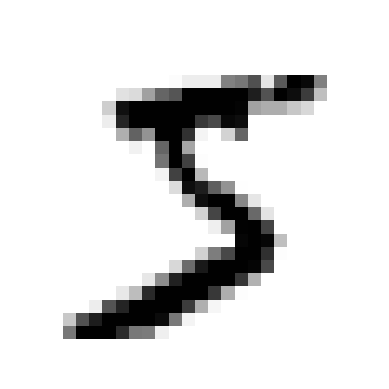

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
y[0]

'5'

In [6]:
# 레이블이 문자열, 대부분의 머신러닝 알고리즘은 숫자를 기대하므로 y를 정수로 변환

import numpy as np

y = y.astype(np.uint8)

In [7]:
# 데이터 자세히 조사하기 전에 항상 테스트 세트 따로 떼어 놓기!!!
# MNIST 데이터셋은 이미 앞쪽 60,000개(훈련 세트), 뒤쪽 10,000개(테스트 세트)로 나눠둠

X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

**[Caution]**
<br> 훈련 세트는 섞여서 모든 교차 검증 폴드를 비슷하게 만들어야 함
<br> 어떤 학습 알고리즘은 훈련 샘플의 순서에 민감해서
<br> 많은 비슷한 샘플이 연이어 나타나면 성능이 나빠짐

### 2. 이진 분류기 훈련

##### 2-1. 이진 분류기
- 찾고 싶은 숫자와 아닌 숫자 분류

In [8]:
# 숫자 5만 식별

y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [9]:
# SGD(stochastic gradient descent)Classifier: 확률적 경사 하강법 분류기
# 매우 큰 데이터셋을 효율적으로 처리하는 장점, 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문
# 그래서 SGD가 온라인 학습에 잘 들어맞음

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

**[Tip]**
<br> SGDClassifier는 훈련하는데 무작위성을 사용(그래서 이름에 확률적이 붙음)
<br> 결과를 재현하고 싶다면 random_state 매개변수 사용

In [11]:
sgd_clf.predict([some_digit])  # some_digit = X[0]를 하나의 샘플로 인식하기 위해 []

array([ True])

### 3. 성능 측정
- 분류기 평가는 회귀 모델보다 훨씬 어려움

##### 3-1. 교차 검증

In [13]:
# 교차 검증 구현

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):  # 3개로 분할된 형태
    clone_clf = clone(sgd_clf)  # sgd_clf의 복사본을 만듬, 각 폴드에 대해 모델을 독립적으로 훈련시키기 위해
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [15]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    print(train_index, test_index)

[    1     3     4 ... 59994 59996 59998] [    0     2     6 ... 59995 59997 59999]
[    0     2     3 ... 59997 59998 59999] [    1    10    11 ... 59988 59989 59991]
[    0     1     2 ... 59995 59997 59999] [    3     4     5 ... 59994 59996 59998]


In [16]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, scoring="accuracy", cv=3)

array([0.95035, 0.96035, 0.9604 ])

In [17]:
# 모든 이미지를 '5아님' 클래스로 분류하는 더미 분류기

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)  # 5가 아니므로 np.zeros로 모두 0을 만들면 False로 반환

In [18]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, scoring="accuracy", cv=3)

# 이미지의 10% 정도만 숫자 5이기 때문에 무조건 5아님으로 예측하면 맞출 확률이 90%

array([0.91125, 0.90855, 0.90915])

- 이 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여줌
- 특히 불균형한 데이터셋을 다룰 때(어떤 클래스가 다른 것보다 월등히 많은 경우) 더욱 그러함

##### 3-2. 오차 행렬